https://qiskit-community.github.io/qiskit-algorithms/tutorials/01_algorithms_introduction.html

In [21]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit.primitives import Estimator

# 1. Construct the observable and circuit
observable = SparsePauliOp.from_list([("XX", 2), ("ZI", 1)])
circuit = QuantumCircuit(2)
circuit.h(0)
circuit.cx(0, 1)

# 2. Initialize the Estimator
estimator = Estimator()
# estimator = Estimator(options={"shots": 1000})

# 3. Run the Estimator
job = estimator.run(circuit, observable)
result = job.result()

# 4. Process the results
expectation_value = result.values[0]

print(f"Expectation value: {expectation_value}")

Expectation value: 1.9999999999999996


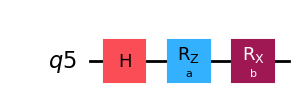

In [27]:
from qiskit.circuit import QuantumCircuit, QuantumRegister, Parameter
from qiskit.quantum_info import SparsePauliOp
import numpy as np

# Instantiate the quantum circuit
a = Parameter("a")
b = Parameter("b")
q = QuantumRegister(1)
qc = QuantumCircuit(q)
qc.h(q)
qc.rz(a, q[0])
qc.rx(b, q[0])

display(qc.draw("mpl"))

# Instantiate the Hamiltonian observable 2X+Z
H = SparsePauliOp.from_list([("X", 2), ("Z", 1)])

# Parameter list
params = [[np.pi / 4, 1]]

In [25]:
from qiskit.primitives import Estimator
from qiskit_algorithms.gradients import ParamShiftEstimatorGradient

# Define the estimator
estimator = Estimator()
# Define the gradient
gradient = ParamShiftEstimatorGradient(estimator)

fun_value = estimator.run(qc, H, params).result().values
# Evaluate the gradient of the circuits using parameter shift gradients
pse_grad_result = gradient.run(qc, H, params).result().gradients

print(pse_grad_result)
print(fun_value)

[array([-0.81920372,  0.38205142])]
[2.0092234]


In [33]:
import numpy as np
from qiskit.primitives import Estimator
from qiskit_algorithms.gradients import ParamShiftEstimatorGradient
from qiskit.circuit import ParameterVector, QuantumCircuit


def tfim_hamiltonian(num_q, J=-1.0, g=-0.5, bc='periodic'):
    """
    构造一维随机场横场伊辛模型（TFIM）的 Hamiltonian：
        H = J * sum_{i} Z_i Z_{i+1} + g * sum_i X_i
    
    参数:
        num_q (int): 量子比特数 (>=1)
        J (float): 最近邻 ZZ 耦合强度
        g (float): 横场 X 强度
        bc (str): 边界条件, 'open' 或 'periodic'
    
    返回:
        SparsePauliOp: 对应的 Hamiltonian
    """
    pauli_list = []
    if num_q == 1:
        raise ValueError("num_q must be greater than 1 for single qubit TFIM model")
    elif num_q == 2:
        pauli_list.append(('ZZ', J))
        pauli_list.append(('XI', g))
        pauli_list.append(('IX', g))
    else:
        # 最近邻 ZZ 相互作用
        for i in range(num_q):
            j = (i + 1) % num_q
            if bc == 'open' and i == num_q - 1:
                continue
            label = ['I'] * num_q
            label[i] = 'Z'
            label[j] = 'Z'
            pauli_list.append((''.join(label), J))

        # 横场 X 项
        for i in range(num_q):
            label = ['I'] * num_q
            label[i] = 'X'
            pauli_list.append((''.join(label), g))

    return SparsePauliOp.from_list(pauli_list)


def build_tfim_hva_circuit(num_q: int, layer: int):
    """
    构造带参数的 HVA TFIM 量子电路与对应的参数向量。
    
    参数:
        num_q (int): 量子比特数
        layer (int): HVA 变分层数
    
    返回:
        param_qc (QuantumCircuit): 带参数的量子电路
        theta (ParameterVector): 参数向量
    """
    num_p = 2 * layer
    theta = ParameterVector("θ", num_p)
    
    circ = QuantumCircuit(num_q)
    # 初始层
    for j in range(num_q):
        circ.h(j)
    # 变分层
    for i in range(layer):
        for j in range(num_q):
            circ.rzz(theta[2 * i], j, (j + 1) % num_q)
        for j in range(num_q):
            circ.rx(theta[2 * i + 1], j)
    
    return circ, theta

def expectation_and_first_grad(num_q: int, layer: int, weights: np.ndarray):
    """
    计算给定 HVA TFIM 电路在 TFIM 哈密顿量下的期望值和对第一个参数的偏导数。
    
    参数:
        num_q (int): 量子比特数
        layer (int): HVA 变分层数
        weights (np.ndarray): 参数数值，长度 = 2*layer
    
    返回:
        expval (float): 期望值
        d0 (float): 对 θ[0] 的偏导数
    """
    # 构造带参数电路
    param_qc, theta = build_tfim_hva_circuit(num_q, layer)
    # 构造 TFIM 哈密顿量
    tfim_op = tfim_hamiltonian(num_q, J=-1.0, g=-0.5, bc='periodic')
    
    # 初始化 Estimator 及梯度计算原语
    est = Estimator()
    grad_est = ParamShiftEstimatorGradient(est)
    
    # 计算期望值
    expval = est.run([param_qc], [tfim_op], [weights]).result().values[0]
    
    # 只对第一个参数 θ[0] 求导
    job = grad_est.run(
        [param_qc],
        [tfim_op],
        [weights],
        parameters=[[theta[0]]]
    )
    d0 = job.result().gradients[0][0]
    
    return expval, d0

# 示例运行
if __name__ == "__main__":
    num_q, layer = 4, 1
    weights = np.random.uniform(0, 2*np.pi, size=2*layer)
    
    expval, d0 = expectation_and_first_grad(num_q, layer, weights)
    print("Expectation =", expval)
    print("d/dθ₀ =", d0)


Expectation = -2.5605644363462368
d/dθ₀ = -1.2685204944152313


In [144]:

def tfim_hamiltonian(num_q, J=-1.0, g=-0.5, bc='periodic'):
    """
    构造一维随机场横场伊辛模型（TFIM）的 Hamiltonian：
        H = J * sum_{i} Z_i Z_{i+1} + g * sum_i X_i
    
    参数:
        num_q (int): 量子比特数 (>=1)
        J (float): 最近邻 ZZ 耦合强度
        g (float): 横场 X 强度
        bc (str): 边界条件, 'open' 或 'periodic'
    
    返回:
        SparsePauliOp: 对应的 Hamiltonian
    """
    pauli_list = []
    if num_q == 1:
        raise ValueError("num_q must be greater than 1 for single qubit TFIM model")
    elif num_q == 2:
        pauli_list.append(('ZZ', J))
        pauli_list.append(('XI', g))
        pauli_list.append(('IX', g))
    else:
        # 最近邻 ZZ 相互作用
        for i in range(num_q):
            j = (i + 1) % num_q
            if bc == 'open' and i == num_q - 1:
                continue
            label = ['I'] * num_q
            label[i] = 'Z'
            label[j] = 'Z'
            pauli_list.append((''.join(label), J))

        # 横场 X 项
        for i in range(num_q):
            label = ['I'] * num_q
            label[i] = 'X'
            pauli_list.append((''.join(label), g))

    return SparsePauliOp.from_list(pauli_list)


In [157]:
from qiskit_algorithms import NumPyMinimumEigensolver
from qiskit.quantum_info import SparsePauliOp


# # 1. 定义哈密顿量
# H_op = SparsePauliOp.from_list([
#     ("II", -1.052373245772859),
#     ("IZ",  0.39793742484318045),
#     ("ZI", -0.39793742484318045),
#     ("ZZ", -0.01128010425623538),
#     ("XX",  0.18093119978423156),
# ])

# from numpy.linalg import eigh

for num_q in range(4, 21):

    print(f"H_op for {num_q} qubits:")

    H_op = tfim_hamiltonian(num_q)

    # 2. 直接用 NumPyMinimumEigensolver
    eigensolver = NumPyMinimumEigensolver()
    result= eigensolver.compute_minimum_eigenvalue(operator=H_op)

    # 3. 取出基态能量和基态
    ground_energy = result.eigenvalue.real
    ground_state  = result.eigenstate  # 这是一个 statevector

    print(f"Ground state energy = {ground_energy}")
    # print(f"Ground state vector = {ground_state}")

    # e, _ = eigh(H_op)
    # Identify the ground state (minimum eigenvalue)
    # ground_e = np.min(e)
    # min_index = np.argmin(e)
    # v_min = v[:, min_index]  # Ground state eigenvector

    # print(f"Ground state energy: {ground_e}")





H_op for 4 qubits:
Ground state energy = -4.271558410139719
H_op for 5 qubits:
Ground state energy = -5.32534306706089
H_op for 6 qubits:
Ground state energy = -6.384694563603702
H_op for 7 qubits:
Ground state energy = -7.446379649852241
H_op for 8 qubits:
Ground state energy = -8.509082235140308
H_op for 9 qubits:
Ground state energy = -9.572239785939788
H_op for 10 qubits:
Ground state energy = -10.635604409348025
H_op for 11 qubits:
Ground state energy = -11.699064532661698
H_op for 12 qubits:
Ground state energy = -12.762569151024136
H_op for 13 qubits:
Ground state energy = -13.82609466844752
H_op for 14 qubits:
Ground state energy = -14.889630066250692
H_op for 15 qubits:
Ground state energy = -15.953170160246964
H_op for 16 qubits:
Ground state energy = -17.016712496347562
H_op for 17 qubits:
Ground state energy = -18.080255906934802
H_op for 18 qubits:
Ground state energy = -19.14379983410849
H_op for 19 qubits:
Ground state energy = -20.207344010333582
H_op for 20 qubits:
Gro